In [144]:

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx



from SALib.analyze import sobol


In [145]:
# make sure pandas is version 1.0 or higher
# make sure networkx is verion 2.4 or higher
print(pd.__version__)
print(nx.__version__)

2.0.2
3.1


In [146]:
from ema_workbench import (
    Model,
    Policy,
    ema_logging,
    SequentialEvaluator,
    MultiprocessingEvaluator,
    perform_experiments,
    Samplers
)
from dike_model_function import DikeNetwork  # @UnresolvedImport
from problem_formulation import get_model_for_problem_formulation, sum_over, sum_over_time

from ema_workbench.em_framework.salib_samplers import get_SALib_problem


In [147]:
ema_logging.log_to_stderr(ema_logging.INFO)

# choose problem formulation number, between 0-5
# each problem formulation has its own list of outcomes
# our objective= minimize total costs

''''
2: expected damages, dike investment costs, rfr costs, evacuation cost, and casualties (choose this)
4: Expected damages, dike investment cost and casualties disaggregated over dike rings and room for the river and evacuation costs (choose this)
'''
dike_model, planning_steps = get_model_for_problem_formulation(2)


In [148]:
# enlisting uncertainties, their types (RealParameter/IntegerParameter/CategoricalParameter), lower boundary, and upper boundary
import copy

for unc in dike_model.uncertainties:
    print(repr(unc))

uncertainties = copy.deepcopy(dike_model.uncertainties)

# location dependent parameters
# Bmax = final breach width (absolute)
# pfail = dike failure probability
# Brate = Breach width model (relative) /day
# ID_flood wafe shape

#discount rate Multiple Decision Points: The dike_model likely involves multiple decision points or stages over time. Each discount rate parameter can correspond to a specific decision point or phase in the model. For example, discount rate 0 may be associated with immediate costs and benefits, discount rate 1 with short-term impacts, and discount rate 2 with long-term consequences. This allows for evaluating the sensitivity of decisions and outcomes to varying discount rates at different stages.


CategoricalParameter('discount rate 0', [0, 1, 2, 3])
CategoricalParameter('discount rate 1', [0, 1, 2, 3])
CategoricalParameter('discount rate 2', [0, 1, 2, 3])
IntegerParameter('A.0_ID flood wave shape', 0, 132, resolution=None, default=None, variable_name=['A.0_ID flood wave shape'], pff=False)
RealParameter('A.1_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.1_Bmax'], pff=False)
RealParameter('A.1_pfail', 0, 1, resolution=None, default=None, variable_name=['A.1_pfail'], pff=False)
CategoricalParameter('A.1_Brate', [0, 1, 2])
RealParameter('A.2_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.2_Bmax'], pff=False)
RealParameter('A.2_pfail', 0, 1, resolution=None, default=None, variable_name=['A.2_pfail'], pff=False)
CategoricalParameter('A.2_Brate', [0, 1, 2])
RealParameter('A.3_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.3_Bmax'], pff=False)
RealParameter('A.3_pfail', 0, 1, resolution=None, default=None, variable_name=['A.3_pfai

In [149]:
# enlisting policy levers, their types (RealParameter/IntegerParameter), lower boundary, and upper boundary


# Each lever has a specific name and range of values denoted by the indexes. Let's break down the levers and their indexes: The indexes indicate the available options or levels for each lever. For example, the '0_RfR 0' lever has two options: 0 and 1. Similarly, the 'A.1_DikeIncrease 0' lever has eleven options from 0 to 10. The specific index value chosen for each lever determines the level or intensity of the intervention applied during the model simulation.
#Rfr: different project:switch on 1 off 0
#Dike_increase: different intensity in dike increase 0 to 10

for policy in dike_model.levers:
    print(repr(policy))

levers = copy.deepcopy(dike_model.levers)

IntegerParameter('0_RfR 0', 0, 1, resolution=None, default=None, variable_name=['0_RfR 0'], pff=False)
IntegerParameter('0_RfR 1', 0, 1, resolution=None, default=None, variable_name=['0_RfR 1'], pff=False)
IntegerParameter('0_RfR 2', 0, 1, resolution=None, default=None, variable_name=['0_RfR 2'], pff=False)
IntegerParameter('1_RfR 0', 0, 1, resolution=None, default=None, variable_name=['1_RfR 0'], pff=False)
IntegerParameter('1_RfR 1', 0, 1, resolution=None, default=None, variable_name=['1_RfR 1'], pff=False)
IntegerParameter('1_RfR 2', 0, 1, resolution=None, default=None, variable_name=['1_RfR 2'], pff=False)
IntegerParameter('2_RfR 0', 0, 1, resolution=None, default=None, variable_name=['2_RfR 0'], pff=False)
IntegerParameter('2_RfR 1', 0, 1, resolution=None, default=None, variable_name=['2_RfR 1'], pff=False)
IntegerParameter('2_RfR 2', 0, 1, resolution=None, default=None, variable_name=['2_RfR 2'], pff=False)
IntegerParameter('3_RfR 0', 0, 1, resolution=None, default=None, variable

In [150]:
# enlisting outcomes
for outcome in dike_model.outcomes:
    print(repr(outcome))

ScalarOutcome('Expected Annual Damage', variable_name=('A.1_Expected Annual Damage', 'A.2_Expected Annual Damage', 'A.3_Expected Annual Damage', 'A.4_Expected Annual Damage', 'A.5_Expected Annual Damage'), function=<function sum_over at 0x00000280F891DB20>)
ScalarOutcome('Dike Investment Costs', variable_name=('A.1_Dike Investment Costs', 'A.2_Dike Investment Costs', 'A.3_Dike Investment Costs', 'A.4_Dike Investment Costs', 'A.5_Dike Investment Costs'), function=<function sum_over at 0x00000280F891DB20>)
ScalarOutcome('RfR Investment Costs', variable_name=('RfR Total Costs',), function=<function sum_over at 0x00000280F891DB20>)
ScalarOutcome('Evacuation Costs', variable_name=('Expected Evacuation Costs',), function=<function sum_over at 0x00000280F891DB20>)
ScalarOutcome('Expected Number of Deaths', variable_name=('A.1_Expected Number of Deaths', 'A.2_Expected Number of Deaths', 'A.3_Expected Number of Deaths', 'A.4_Expected Number of Deaths', 'A.5_Expected Number of Deaths'), function

In [151]:
# running the model through EMA workbench
with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(scenarios=200, policies=4)

[MainProcess/INFO] pool started with 8 workers
[MainProcess/INFO] performing 200 scenarios * 4 policies * 1 model(s) = 800 experiments
 95%|█████████████████████████████████████▉  | 759/800 [02:25<00:07,  5.50it/s][MainProcess/INFO] terminating pool


KeyboardInterrupt: 

In [ ]:
# observing the simulation runs
experiments, outcomes = results
print(outcomes.keys())


# Location dependent
# total costs
# expected number ot deaths
# RfR Total Costs
# Expected Evacuation costs



In [ ]:
# only works because we have scalar outcomes
sns.pairplot(pd.DataFrame.from_dict(outcomes))
plt.show()
plt.savefig('outcomes vs outcome')

In [ ]:
# plot here outcome vs. outcome dependend on policy

policies = experiments['policy']

data = pd.DataFrame.from_dict(outcomes)
data['policy'] = policies

sns.pairplot(data, hue='policy',  vars=outcomes.keys(), )
plt.show()



In [ ]:
experiments_df = pd.DataFrame.from_dict(experiments)

#apply filter
experiments_df[experiments_df['policy']==0]

In [ ]:
# defining specific policies
# for example, policy 1 is about extra protection in upper boundary
# policy 2 is about extra protection in lower boundary
# policy 3 is extra protection in random locations

# BAU = Rfr (x,t) ; Dike increase (x,t) =0
# Dike heightening scenario RFR=0 Dike heigth = 5
#


def get_do_nothing_dict():
    return {l.name: 0 for l in dike_model.levers}


policies = [
    Policy(
        "BAU",
        **dict(
            get_do_nothing_dict()
        )
    ),
    Policy(
        "Dike Increase medium",
        **dict(get_do_nothing_dict(),
                **{'A.1_DikeIncrease 0':5,
                  'A.1_DikeIncrease 1':5,
                  'A.1_DikeIncrease 2':5,
                  'A.2_DikeIncrease 0':5,
                  'A.2_DikeIncrease 1':5,
                  'A.2_DikeIncrease 2':5,
                  'A.3_DikeIncrease 0':5,
                  'A.3_DikeIncrease 1':5,
                  'A.3_DikeIncrease 2':5,
                  'A.4_DikeIncrease 0':5,
                  'A.4_DikeIncrease 1':5,
                  'A.4_DikeIncrease 2':5,
                  'A.5_DikeIncrease 0':5,
                  'A.5_DikeIncrease 1':5,
                  'A.5_DikeIncrease 2':5})
    ),
    Policy(
        "Dike Increase high",
        **dict(
            get_do_nothing_dict(),
           **{'A.1_DikeIncrease 0':5,
                  'A.1_DikeIncrease 1':10,
                  'A.1_DikeIncrease 2':10,
                  'A.2_DikeIncrease 0':10,
                  'A.2_DikeIncrease 1':10,
                  'A.2_DikeIncrease 2':10,
                  'A.3_DikeIncrease 0':10,
                  'A.3_DikeIncrease 1':10,
                  'A.3_DikeIncrease 2':10,
                  'A.4_DikeIncrease 0':10,
                  'A.4_DikeIncrease 1':10,
                  'A.4_DikeIncrease 2':10,
                  'A.5_DikeIncrease 0':10,
                  'A.5_DikeIncrease 1':10,
                  'A.5_DikeIncrease 2':10}
        )
    ),
]

In [ ]:
# pass the policies list to EMA workbench experiment runs
n_scenarios = 100
with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios, policies)

In [ ]:
experiments, outcomes = results

In [182]:
from utility_functions import *

print(get_stat_par(outcomes, policies)['BAU'])


                                              Expected Annual Damage  \
mean                                               1668357036.474524   
mode               (74498128.99083754, 139031402.14978272, 158231...   
median                                             1823276059.031569   
stdev                                               1163552341.78745   
min                                                  74498128.990838   
max                                                 5491686817.71049   
range                                              5417188688.719653   
iqr                                                2246550544.567757   
first_q                                             406702226.299603   
third_q                                            2653252770.867359   
Quartile distance                                  1123275272.283878   
skewness                                                    0.304644   
kurtosis                                                   -0.52

C:\Users\admin\Documents\GitHub\MBDM_Group5\utility_functions.py:70: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skewness = stats.skew(data)
C:\Users\admin\Documents\GitHub\MBDM_Group5\utility_functions.py:72: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = stats.kurtosis(data)
C:\Users\admin\Documents\GitHub\MBDM_Group5\utility_functions.py:70: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skewness = stats.skew(data)
C:\Users\admin\Documents\GitHub\MBDM_Group5\utility_functions.py:72: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the 

In [ ]:
policies = experiments['policy']

data = pd.DataFrame.from_dict(outcomes)
data['policy'] = policies

sns.pairplot(data, hue='policy',  vars=outcomes.keys(), )
plt.show()
plt.savefig('outcome vs outcome first experiments')




In [ ]:
from ema_workbench.em_framework.salib_samplers import get_SALib_problem

In [ ]:
'''
Sensitivity Analysis of the Uncertainty space respective to the Outcome
'''


sa_senarios=1000

with MultiprocessingEvaluator(dike_model) as evaluator:
    sa_results = evaluator.perform_experiments(scenarios=sa_senarios,policies=1, uncertainty_sampling=Samplers.SOBOL)


In [ ]:
experiments_sa, outcomes_sa = sa_results

outcomes_sa_df= pd.DataFrame.from_dict(outcomes_sa)

# safe outcomes to csv / json
outcomes_sa_df.to_json('sobol experiment outcomes_1000 scenarios')




In [62]:
'Do sensitivity Analysis for uncertainty space outcome'
outcomes_sa_col = outcomes_sa_df.columns

problem = get_SALib_problem(uncertainties)

results_Si =dict()

for item in outcomes_sa_df.columns:
    results_Si[item] = sobol.analyze(problem, outcomes_sa[item], calc_second_order=True, print_to_console=True, parallel=True)






                                   ST       ST_conf
A.0_ID flood wave shape  2.456661e-02  6.345821e-03
A.1_Bmax                 6.050223e-11  1.242312e-10
A.1_Brate                0.000000e+00  0.000000e+00
A.1_pfail                2.493780e-06  2.710992e-06
A.2_Bmax                 3.458477e-04  3.345166e-04
A.2_Brate                1.487960e-05  1.581682e-05
A.2_pfail                3.325282e-02  1.398714e-02
A.3_Bmax                 0.000000e+00  0.000000e+00
A.3_Brate                0.000000e+00  0.000000e+00
A.3_pfail                1.170139e-05  1.554520e-05
A.4_Bmax                 1.385139e-06  3.129880e-06
A.4_Brate                0.000000e+00  0.000000e+00
A.4_pfail                1.115266e-04  1.564150e-04
A.5_Bmax                 0.000000e+00  0.000000e+00
A.5_Brate                0.000000e+00  0.000000e+00
A.5_pfail                9.886717e-01  8.739249e-02
discount rate 0          1.655868e-02  3.425463e-03
discount rate 1          1.895034e-02  3.747585e-03
discount rat

C:\Users\admin\Documents\GitHub\MBDM_Group5\venv\Lib\site-packages\SALib\analyze\sobol.py:129: RuntimeWarning: invalid value encountered in divide
  Y = (Y - Y.mean()) / Y.std()


                         ST  ST_conf
A.0_ID flood wave shape NaN      NaN
A.1_Bmax                NaN      NaN
A.1_Brate               NaN      NaN
A.1_pfail               NaN      NaN
A.2_Bmax                NaN      NaN
A.2_Brate               NaN      NaN
A.2_pfail               NaN      NaN
A.3_Bmax                NaN      NaN
A.3_Brate               NaN      NaN
A.3_pfail               NaN      NaN
A.4_Bmax                NaN      NaN
A.4_Brate               NaN      NaN
A.4_pfail               NaN      NaN
A.5_Bmax                NaN      NaN
A.5_Brate               NaN      NaN
A.5_pfail               NaN      NaN
discount rate 0         NaN      NaN
discount rate 1         NaN      NaN
discount rate 2         NaN      NaN
                         S1  S1_conf
A.0_ID flood wave shape NaN      NaN
A.1_Bmax                NaN      NaN
A.1_Brate               NaN      NaN
A.1_pfail               NaN      NaN
A.2_Bmax                NaN      NaN
A.2_Brate               NaN      NaN
A

C:\Users\admin\Documents\GitHub\MBDM_Group5\venv\Lib\site-packages\SALib\analyze\sobol.py:129: RuntimeWarning: invalid value encountered in divide
  Y = (Y - Y.mean()) / Y.std()


                         ST  ST_conf
A.0_ID flood wave shape NaN      NaN
A.1_Bmax                NaN      NaN
A.1_Brate               NaN      NaN
A.1_pfail               NaN      NaN
A.2_Bmax                NaN      NaN
A.2_Brate               NaN      NaN
A.2_pfail               NaN      NaN
A.3_Bmax                NaN      NaN
A.3_Brate               NaN      NaN
A.3_pfail               NaN      NaN
A.4_Bmax                NaN      NaN
A.4_Brate               NaN      NaN
A.4_pfail               NaN      NaN
A.5_Bmax                NaN      NaN
A.5_Brate               NaN      NaN
A.5_pfail               NaN      NaN
discount rate 0         NaN      NaN
discount rate 1         NaN      NaN
discount rate 2         NaN      NaN
                         S1  S1_conf
A.0_ID flood wave shape NaN      NaN
A.1_Bmax                NaN      NaN
A.1_Brate               NaN      NaN
A.1_pfail               NaN      NaN
A.2_Bmax                NaN      NaN
A.2_Brate               NaN      NaN
A

In [64]:
results_Si

{'Expected Annual Damage': {'S1': array([ 1.01791085e-02, -6.41061150e-08,  0.00000000e+00, -1.87195902e-05,
          1.51202854e-03,  3.53415446e-05,  2.48826417e-02,  0.00000000e+00,
          0.00000000e+00,  2.19812903e-05, -4.97891222e-06,  0.00000000e+00,
          6.19289643e-04,  0.00000000e+00,  0.00000000e+00,  9.26643294e-01,
          4.63664293e-03,  9.06490398e-03, -3.97903510e-03]),
  'S1_conf': array([1.24857015e-02, 1.31631185e-07, 0.00000000e+00, 7.76444364e-05,
         1.67977725e-03, 2.98979807e-04, 2.40433331e-02, 0.00000000e+00,
         0.00000000e+00, 5.61169362e-05, 1.12504167e-05, 0.00000000e+00,
         9.09174562e-04, 0.00000000e+00, 0.00000000e+00, 1.68221032e-01,
         1.25208724e-02, 1.02442994e-02, 4.58434401e-03]),
  'ST': array([2.45666140e-02, 6.05022311e-11, 0.00000000e+00, 2.49377997e-06,
         3.45847743e-04, 1.48796047e-05, 3.32528170e-02, 0.00000000e+00,
         0.00000000e+00, 1.17013906e-05, 1.38513945e-06, 0.00000000e+00,
         1.

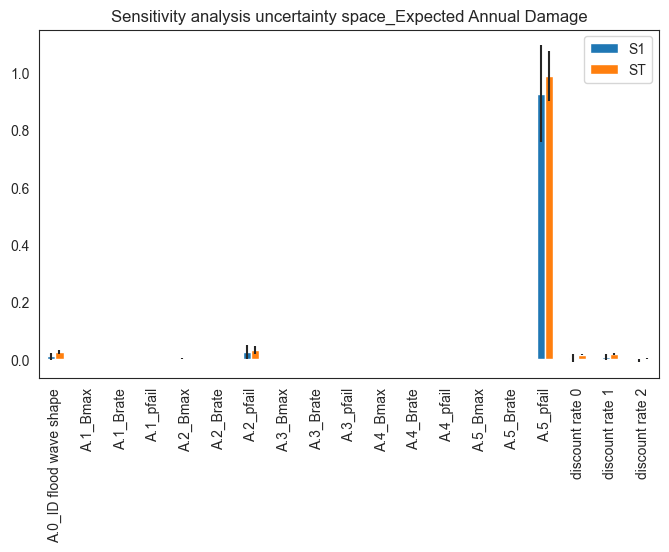

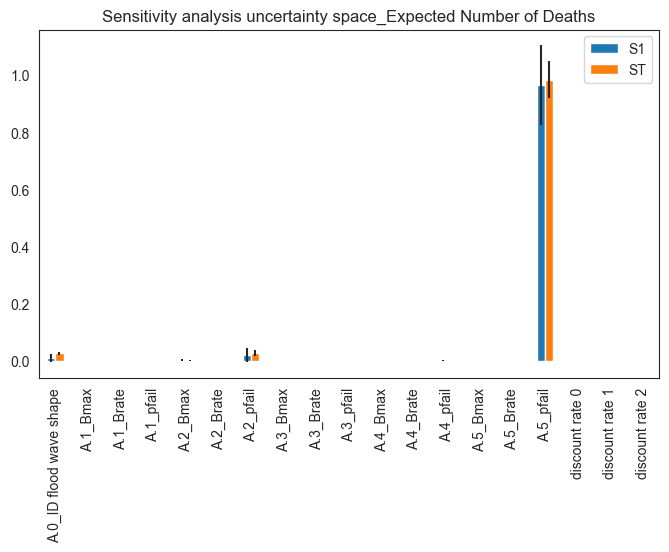

In [66]:

Si_filter=dict()

for item in ['Expected Annual Damage','Expected Number of Deaths']:
    Si_filter[item] = {k:results_Si[item][k] for k in ['ST','ST_conf','S1','S1_conf']}
    Si_df = pd.DataFrame(Si_filter[item], index=problem['names'])

    sns.set_style('white')
    fig, ax = plt.subplots(1)

    indices = Si_df[['S1','ST']]
    err = Si_df[['S1_conf','ST_conf']]

    indices.plot.bar(yerr=err.values.T,ax=ax)
    fig.set_size_inches(8,6)
    fig.subplots_adjust(bottom=0.3)
    plt.title(f"Sensitivity analysis uncertainty space_{item}")
    plt.savefig(f"Sensitivity analysis uncertainty space_{item}")
    plt.show()



In [60]:
Si_filter

{'Expected Annual Damage': {'ST': array([2.45666140e-02, 6.05022311e-11, 0.00000000e+00, 2.49377997e-06,
         3.45847743e-04, 1.48796047e-05, 3.32528170e-02, 0.00000000e+00,
         0.00000000e+00, 1.17013906e-05, 1.38513945e-06, 0.00000000e+00,
         1.11526601e-04, 0.00000000e+00, 0.00000000e+00, 9.88671728e-01,
         1.65586762e-02, 1.89503375e-02, 3.13906258e-03]),
  'ST_conf': array([6.11126398e-03, 1.21204859e-10, 0.00000000e+00, 2.93762655e-06,
         3.31938114e-04, 1.73097271e-05, 1.37408717e-02, 0.00000000e+00,
         0.00000000e+00, 2.11492003e-05, 3.01593416e-06, 0.00000000e+00,
         1.82382129e-04, 0.00000000e+00, 0.00000000e+00, 9.14938341e-02,
         3.40672631e-03, 4.33756374e-03, 1.65763688e-03]),
  'S1': array([ 1.01791085e-02, -6.41061150e-08,  0.00000000e+00, -1.87195902e-05,
          1.51202854e-03,  3.53415446e-05,  2.48826417e-02,  0.00000000e+00,
          0.00000000e+00,  2.19812903e-05, -4.97891222e-06,  0.00000000e+00,
          6.192896

In [27]:
'Define a boundary for ST min that is considered for analysis.'

print(Si_df[Si_df['ST']>0.01])

                               ST   ST_conf        S1   S1_conf
A.0_ID flood wave shape  0.024567  0.005932  0.010179  0.012316
A.2_pfail                0.033253  0.013514  0.024883  0.022364
A.5_pfail                0.988672  0.076376  0.926643  0.135785
discount rate 0          0.016559  0.003286  0.004637  0.012648
discount rate 1          0.018950  0.004461  0.009065  0.011076


In [28]:
'Now we tackle the sensitivity analysis for the lever space'
sa_scenarios=1000

with MultiprocessingEvaluator(dike_model) as evaluator:
    sa_results_lever = evaluator.perform_experiments(scenarios=sa_scenarios, policies=1, lever_sampling=Samplers.SOBOL)




[MainProcess/INFO] pool started with 8 workers
[MainProcess/INFO] performing 1000 scenarios * 64 policies * 1 model(s) = 64000 experiments
100%|██████████████████████████████████| 64000/64000 [3:03:05<00:00,  5.83it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [67]:

experiments_sa_lever, outcomes_sa_lever = sa_results_lever

outcomes_sa_lever_df= pd.DataFrame.from_dict(outcomes_sa_lever)

outcomes_sa_lever_df.to_csv('sobol lever space outcomes_1000 scenarios')

In [48]:

'Do sensitivity Analysis for uncertainty space outcome'


outcomes_sa_lever_col = outcomes_sa_lever_df.columns

problem = get_SALib_problem(levers)


results_Si_lever =dict()


for item in outcomes_sa_lever_df.columns:
    results_Si_lever[item] = sobol.analyze(problem, outcomes_sa_lever[item], calc_second_order=True, print_to_console=True, parallel=True)




                          ST   ST_conf
0_RfR 0             1.444646  0.538057
0_RfR 1             1.712239  0.771647
0_RfR 2             1.291085  0.592990
1_RfR 0             1.240225  0.460684
1_RfR 1             0.880554  0.352500
1_RfR 2             0.940856  0.283279
2_RfR 0             1.030399  0.331562
2_RfR 1             1.024250  0.372281
2_RfR 2             1.264268  0.423156
3_RfR 0             1.821009  0.793434
3_RfR 1             1.576707  0.663361
3_RfR 2             1.309292  0.551092
4_RfR 0             0.868357  0.260812
4_RfR 1             1.042901  0.409564
4_RfR 2             0.756092  0.371715
A.1_DikeIncrease 0  0.796874  0.354139
A.1_DikeIncrease 1  1.272328  0.372505
A.1_DikeIncrease 2  1.673065  0.837770
A.2_DikeIncrease 0  1.601908  0.523952
A.2_DikeIncrease 1  1.229686  0.505406
A.2_DikeIncrease 2  0.920746  0.322313
A.3_DikeIncrease 0  1.028587  0.375379
A.3_DikeIncrease 1  1.140062  0.378291
A.3_DikeIncrease 2  1.101394  0.412884
A.4_DikeIncrease 0  1.438

In [49]:
Si_filter_lever = dict()

for item in outcomes_sa_lever_col:
    Si_filter_lever[item] = {k:results_Si_lever[item][k] for k in ['ST','ST_conf','S1','S1_conf']}



In [51]:
Si_filter_lever_df= pd.DataFrame.from_dict(Si_filter_lever['Expected Annual Damage'])

Si_filter_lever_df.index = problem['names']

print(Si_filter_lever_df)


                          ST   ST_conf        S1   S1_conf
0_RfR 0             1.444646  0.538057 -0.027572  0.048310
0_RfR 1             1.712239  0.771647 -0.032227  0.053147
0_RfR 2             1.291085  0.592990 -0.075559  0.042252
1_RfR 0             1.240225  0.460684  0.059469  0.064981
1_RfR 1             0.880554  0.352500  0.014930  0.074458
1_RfR 2             0.940856  0.283279 -0.018975  0.027673
2_RfR 0             1.030399  0.331562  0.225013  0.208492
2_RfR 1             1.024250  0.372281 -0.025371  0.029552
2_RfR 2             1.264268  0.423156 -0.018060  0.041207
3_RfR 0             1.821009  0.793434 -0.036830  0.037691
3_RfR 1             1.576707  0.663361  0.057779  0.099887
3_RfR 2             1.309292  0.551092 -0.016579  0.056780
4_RfR 0             0.868357  0.260812  0.186699  0.180727
4_RfR 1             1.042901  0.409564 -0.032108  0.033323
4_RfR 2             0.756092  0.371715  0.135568  0.161919
A.1_DikeIncrease 0  0.796874  0.354139 -0.017985  0.0258

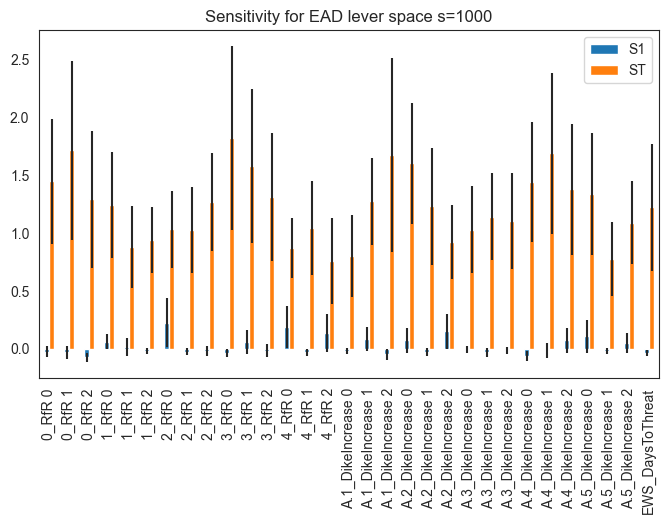

In [52]:
sns.set_style('white')
fig, ax = plt.subplots(1)

indices = Si_filter_lever_df[['S1','ST']]
err = Si_filter_lever_df[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(8,6)
fig.subplots_adjust(bottom=0.3)
plt.title('Sensitivity for EAD lever space s=1000')
plt.savefig('Sensitivity analysis lever space_EAD')
plt.show()


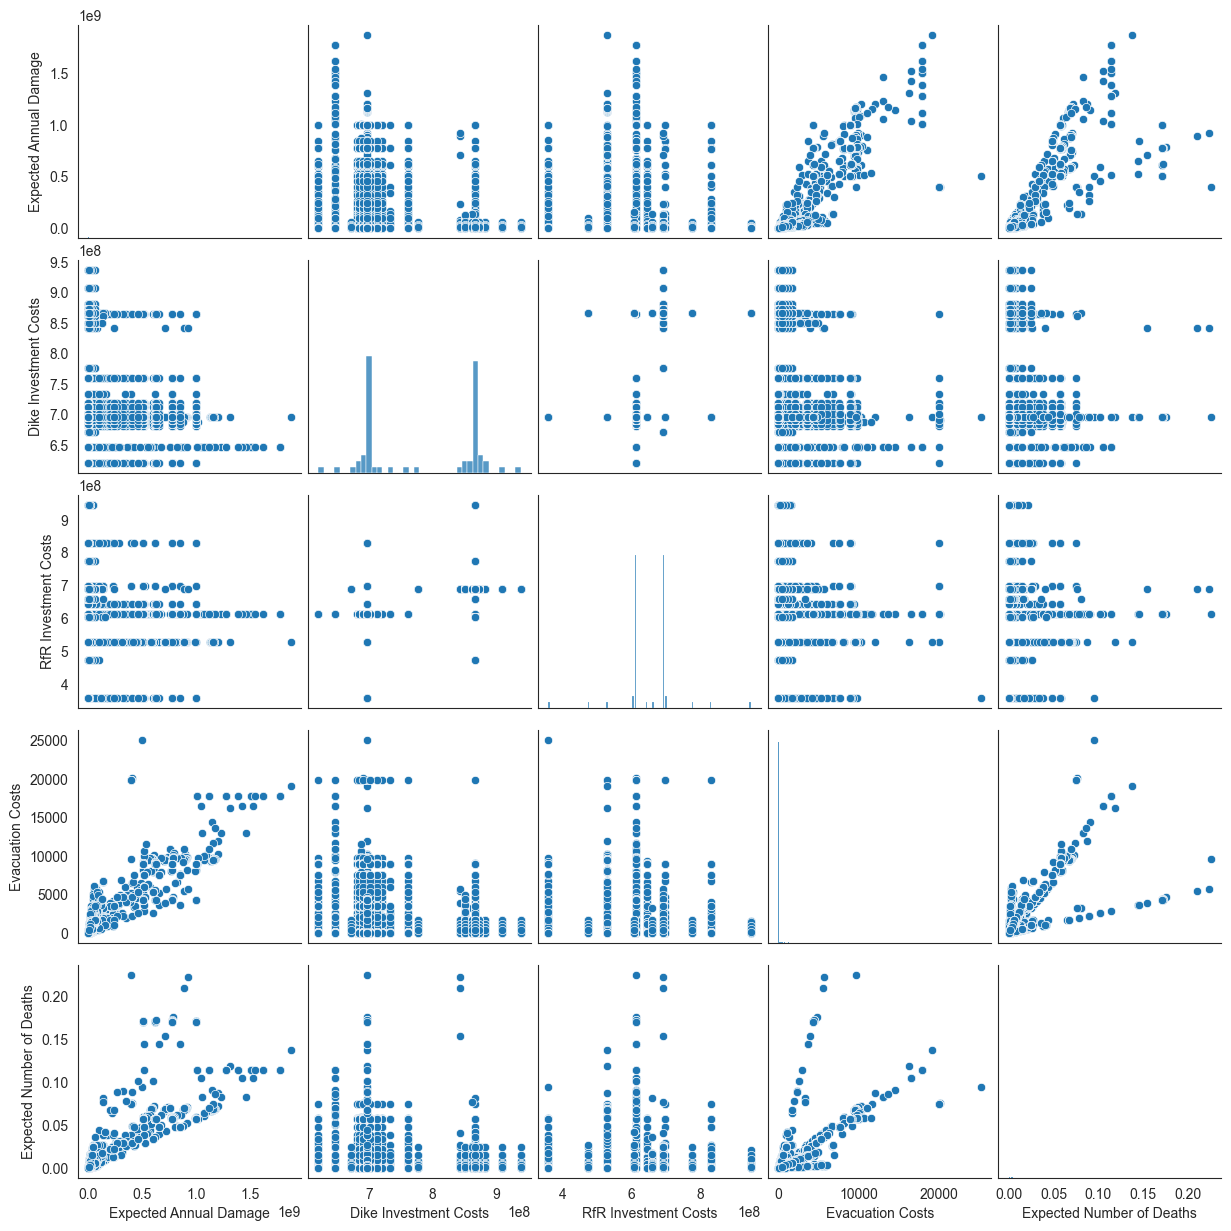

In [80]:

sns.pairplot(outcomes_sa_lever_df)
plt.savefig('Outcome distribution for the lever space')
plt.show()

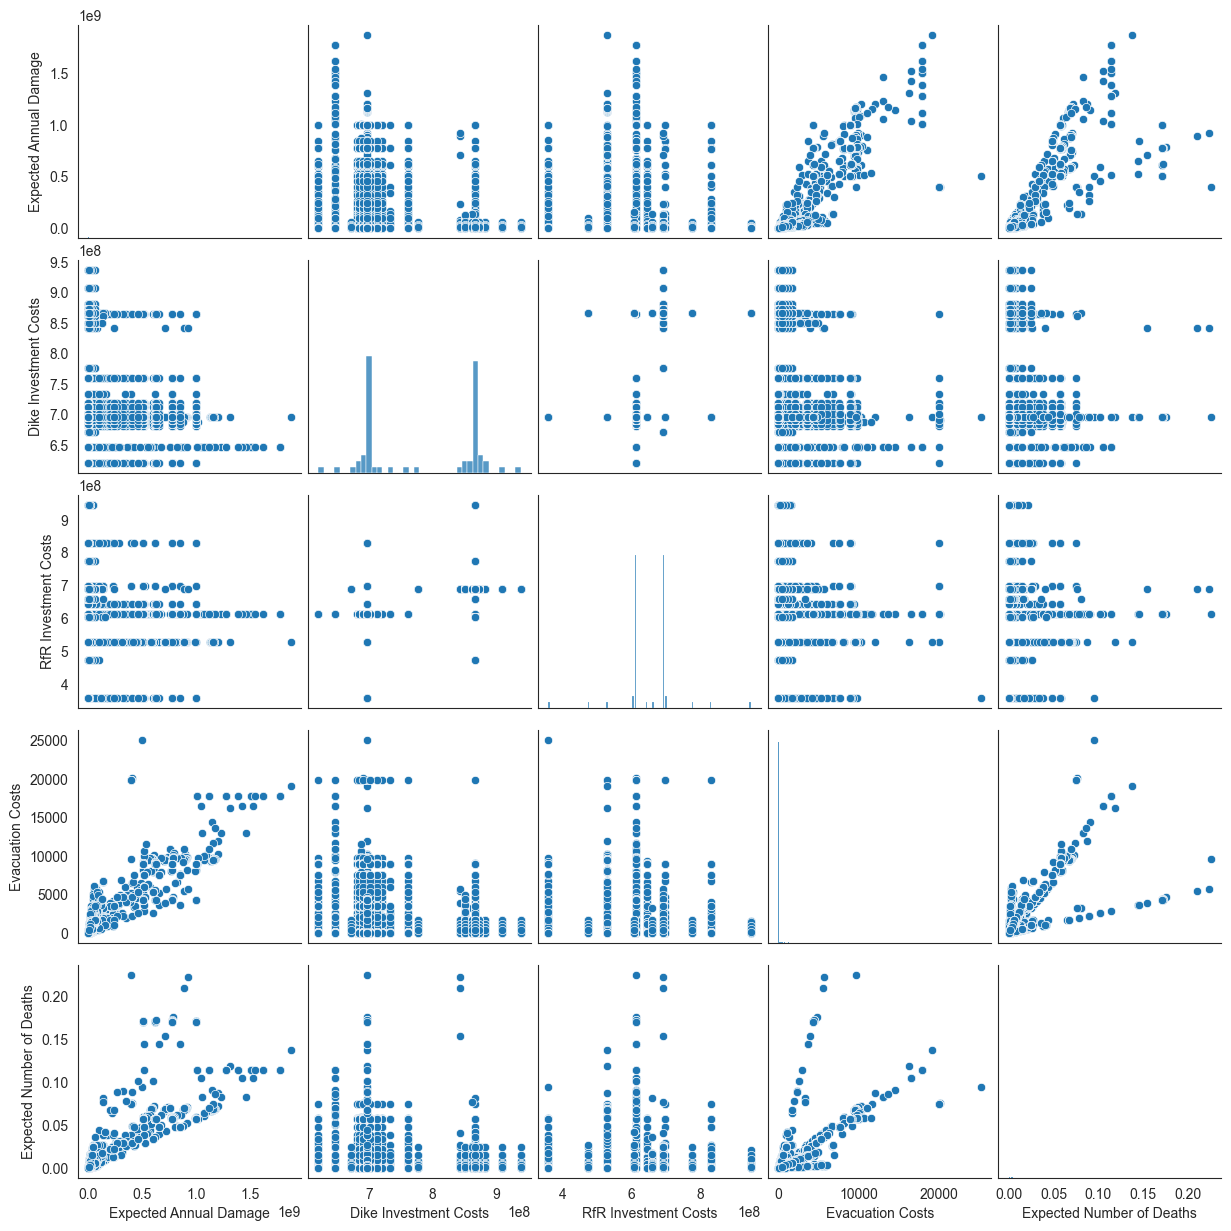

In [81]:
sns.pairplot(outcomes_sa_df)
plt.savefig('Outcome distribution for the uncertainty space')
plt.show()

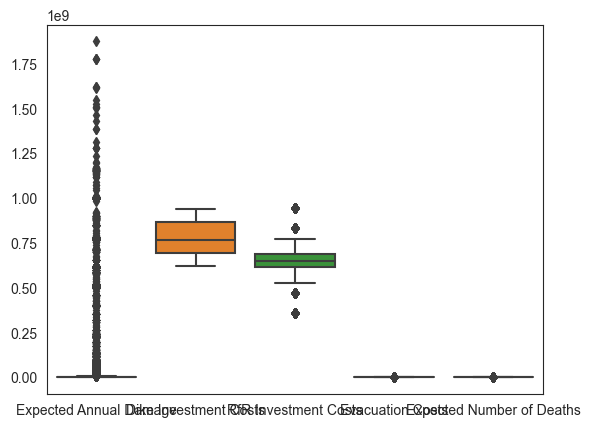

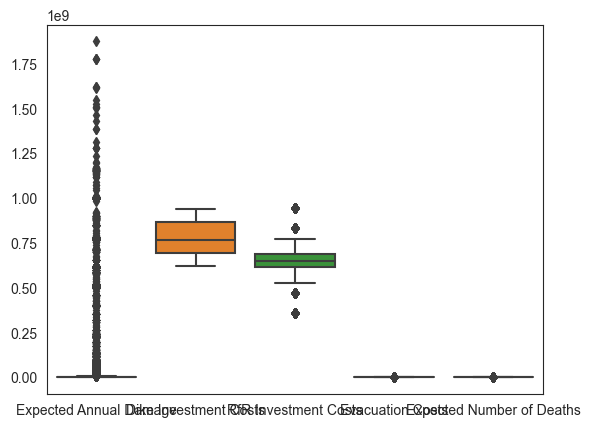

In [106]:
'Boxplot uncertainty space'

sns.boxplot(outcomes_sa_df)

plt.show()

'Boxplot lever space'

sns.boxplot(outcomes_sa_lever_df)
plt.show()


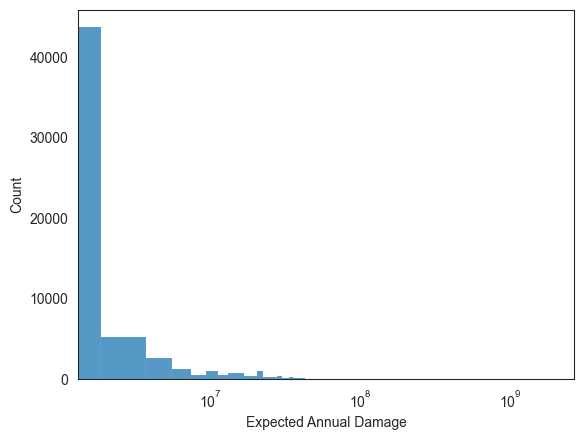

<Figure size 640x480 with 0 Axes>

In [101]:
sns.histplot(outcomes_sa_df['Expected Annual Damage'], bins=1000)
plt.xscale('log')
plt.show()
plt.savefig('EAD distribution uncertainty experiment')